# Demo multi-site traces

author: laquitainesteeve@gmail.com

Purpose: describe the multi-site spatio-temporal dynamics of action potentials.

Execution time: 2 min

## Setup

Create and activate virtual environment kernel `demo` from (envs/demo.yml)

In [136]:
%load_ext autoreload
%autoreload 2

# import packages
import os
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface as si
from matplotlib import pyplot as plt;
print("spikeinterface version:", si.__version__)

# dandiset parameters
dandiset_id = '001250'
filepath = 'sub-demo-dataset/sub-demo-dataset_ecephys.nwb'

# project path
proj_path = "/Users/steeve_laquitaine/Desktop/EPFL/2022_2024_bbp/spikebias/"
# proj_path = "/home/jovyan/steevelaquitaine/spikebias/"
os.chdir(proj_path)

# import spikebias package
from src.nodes.utils import get_config

# configuration of the evoked biophy. simulation at 20 kHz
cfg, param_cfg = get_config("silico_neuropixels", "npx_evoked").values()

# preprocessing parameters
FREQ_MIN = param_cfg["run"]["preprocessing"]["min_filter_freq"]
FREQ_MAX = param_cfg["run"]["preprocessing"]["max_filter_freq"]

# compute parameters
STIM_START = 30000        # arbitrary start of a stimulus (example)
START_AFTER_STIM_MS = 10  # start to plot 10 ms after the stimulus to capture most of its effect which seems delayed
DURATION = 10             # plotted recording duration in ms

# plot parameters
LINEWIDTH_BORD = 0.25
FIGSIZE = (1.3, 5.9)
PLOT_Y_PITCH = 20
LINEWIDTH = 0.5
Y_MAX = PLOT_Y_PITCH * 95


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spikeinterface version: 0.101.2
2025-04-05 12:31:35,884 - root - utils.py - get_config - INFO - Reading experiment config.
2025-04-05 12:31:35,960 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Load dandiset demo

In [137]:
%%time

# get the extractors from Dandi archive
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
Recording = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile")
Sorting = se.NwbSortingExtractor(file_path=s3_path, stream_mode="remfile")

# load voltage traces 
traces = Recording.get_traces()

# report info
print("s3_path:", s3_path)
print('\n Recording extractor:', Recording)
print('\n Layers in demo:', np.unique(Recording.get_property('layers')))
print("\n Trace data shape:", traces.shape)
print('\n Sorting extractor:', Sorting)

s3_path: https://dandiarchive.s3.amazonaws.com/blobs/df4/087/df4087b5-6898-469e-8261-1dcf1413bde3

 Recording extractor: NwbRecordingExtractor: 120 channels - 20.0kHz - 1 segments - 1,200,000 samples 
                       60.00s (1.00 minutes) - float32 dtype - 549.32 MiB
  file_path: https://dandiarchive.s3.amazonaws.com/blobs/df4/087/df4087b5-6898-469e-8261-1dcf1413bde3

 Layers in demo: ['L5' 'L6']

 Trace data shape: (1200000, 120)

 Sorting extractor: NwbSortingExtractor: 1836 units - 1 segments - 20.0kHz
  file_path: https://dandiarchive.s3.amazonaws.com/blobs/df4/087/df4087b5-6898-469e-8261-1dcf1413bde3
CPU times: user 17.9 s, sys: 2.95 s, total: 20.9 s
Wall time: 1min 13s


## Compute multi-site data

In [138]:
%%time 

# compress to int16 (like the Kilosort sorters)
# apply band-pass filter and common referencing
Recording = spre.astype(Recording, "int16")
Recording = spre.bandpass_filter(
    Recording, freq_min=FREQ_MIN, freq_max=FREQ_MAX
)
Recording = spre.common_reference(
    Recording, reference="global", operator="median"
)

# load voltage traces, site layers metadata
# note: contact ids from 380 (superficial sites near pial) to 0 (deeper sites)
traces_pre = Recording.get_traces()
layers = Recording.get_property("layers")
SAMPFREQ = int(Recording.get_sampling_frequency())
N_SAMP = int(START_AFTER_STIM_MS / 1000 * SAMPFREQ)
n_timepoints = int(DURATION * SAMPFREQ / 1000) # plotted recording duration in sample

# set plotting period
PERIOD = np.arange(
    STIM_START + N_SAMP,
    STIM_START + N_SAMP + n_timepoints,
    1,
)

# get voltage traces array
n_contacts = prep_traces.shape[1]

# setup plotting dataset
fig_data = {
    "trace": traces_pre[PERIOD, :],
    "layers": layers
}

# get site ids in layer 5 or 6 and in the probe's first column
# note: original channel ids are ordered from 1 to 384.
# sites in layer "L5" or L6" and in the probe's first column
site_ids  = Recording.get_channel_ids()
col1_site_l5 = site_ids[(layers=="L5") & (site_ids.astype(int) <= 96)].astype(int)
col1_site_l6 = site_ids[(layers=="L6") & (site_ids.astype(int) <= 96)].astype(int)
n_sites_to_plot = len(col1_site_l5) + len(col1_site_l6)
print("# sites in column 1 and in layer 5 or 6:", n_sites_to_plot)

# sites in column 1 and in layer 5 or 6: 30
CPU times: user 20.9 s, sys: 5.48 s, total: 26.4 s
Wall time: 28.6 s


## Plot

CPU times: user 95.5 ms, sys: 20 ms, total: 116 ms
Wall time: 315 ms


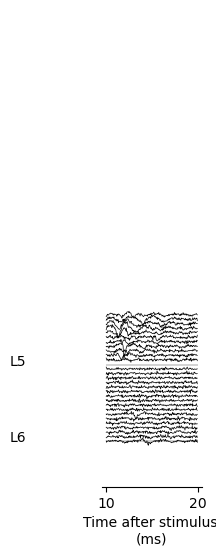

In [140]:
%%time 

# plot (0: bottom 96:top)
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
pos_up = 0
row = 0

# loop over the sites
for site_id in np.arange(col1_site_l6[0], col1_site_l5[-1], 1):

    # identify the first trace of each layer
    # layer 6
    if site_id == col1_site_l6[0]:
        ax.hlines(
            y=0.98 * pos_up,
            xmin=0,
            xmax=n_timepoints,
            color="black",
            linewidth=LINEWIDTH_BORD,
        )
        # label layer
        ax.text(
            # 610,
            -210,
            0.99 * pos_up,
            "%s" % ("L6"),
            size=plt.rcParams["font.size"],
            zorder=100,
            color="k",
            ha="left",
        )
    # layer 5
    if site_id == col1_site_l5[0]:
        ax.hlines(
            y=0.99 * pos_up,
            xmin=0,
            xmax=n_timepoints,
            color="black",
            linewidth=LINEWIDTH_BORD,
        )
        # label layer
        ax.text(
            # 610,
            -210,
            0.99 * pos_up,
            "%s" % ("L5"),
            size=plt.rcParams["font.size"],
            zorder=100,
            color="k",
            ha="left",
        )

    # all other traces
    else:
        ax.plot(
            fig_data["trace"][:, site_id] + pos_up,
            linewidth=LINEWIDTH,
            color="k",
        )
    pos_up += PLOT_Y_PITCH

# legend
ax.spines[["left", "right", "top"]].set_visible(False)
ax.set_xticks([0, n_timepoints], [START_AFTER_STIM_MS, START_AFTER_STIM_MS + DURATION])
ax.set_xlabel("Time after stimulus \n(ms)")
ax.set_ylim([-100, Y_MAX + 10])
plt.yticks([])

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("right")